# Multi-View DenseNet121 Training

This notebook demonstrates the training of a Multi-View DenseNet121 model for mammogram classification.

The notebook is organized as follows:
1. Setup and Imports
2. Configuration and Data Paths
3. Data Loading and Preprocessing
4. Model Creation and Training Setup
5. Training Loop
6. Memory Management

In [81]:
## Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import v2 as transforms
from torch.utils.data import DataLoader, Dataset
import time
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [82]:
## Import Model and Dataset
from MakeDataset_VinDr_classification import MakeDataset_VinDr_classification
from models.densenet121 import create_model  # Imports from models/densenet121.py

In [83]:
## Devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available GPUs: ", torch.cuda.device_count())
print("Current device ID: ", torch.cuda.current_device())

Available GPUs:  1
Current device ID:  0


In [84]:
## Configuration
extension = ".png"
target_size = 384  # DenseNet can work with different input sizes
batch_size = 8
learning_rate = 1e-4
epochs = 5
threshold = 0.5
weight_decay = 1e-3

In [85]:
## Data Paths
image_dir = "test-dataset/"
label_dir_csv = "test-dataset/full_path.csv"

In [86]:
## Data Loaders
from torch.utils.data import Subset, DataLoader
import numpy as np
from collections import Counter
# Define transforms - DenseNet expects normalized inputs
transform = transforms.Compose([
    transforms.Resize((target_size, target_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Create the full dataset
full = MakeDataset_VinDr_classification(
    image_dir=image_dir,
    label_csv=label_dir_csv,
    transform=transform,
    mode='train',  # mode doesn't matter here since we're splitting manually
    split_size=0.0,  # No need for internal splitting
    target_size=target_size
)

# Get total size and create permuted indices
total = len(full)
indices = np.random.RandomState(42).permutation(total)

# Calculate split sizes (70% train, 15% val, 15% test)
train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size  # Use remaining to avoid rounding issues

# Split indices for each set
train_idx = indices[:train_size]
val_idx = indices[train_size:train_size + val_size]
test_idx = indices[train_size + val_size:]

# Create subsets
train_subset = Subset(full, train_idx)
val_subset = Subset(full, val_idx)
test_subset = Subset(full, test_idx)

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
def get_label_distribution(subset, name="Subset"):
    labels = [subset.dataset.samples[i][2] for i in subset.indices]
    counter = Counter(labels)
    total = sum(counter.values())
    print(f"\n{name} Class Distribution:")
    for cls, count in counter.items():
        label_name = f"Class {cls} ({'Benign' if cls == 0 else 'Malignant'})"
        print(f"{label_name}: {count} samples ({(count / total) * 100:.2f}%)")
    print(f"Total samples: {total}")

# Print class distributions
get_label_distribution(train_subset, "Train")
get_label_distribution(val_subset, "Validation")
get_label_distribution(test_subset, "Test")
# Print split sizes to verify
print(f"Total dataset size: {total}")
print(f"Training set size: {len(train_subset)} ({len(train_subset)/total:.1%})")
print(f"Validation set size: {len(val_subset)} ({len(val_subset)/total:.1%})")
print(f"Test set size: {len(test_subset)} ({len(test_subset)/total:.1%})")


/home/intern04/miniconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(



View distribution:
view_position
MLO    516
CC     504
Name: count, dtype: int64

Laterality distribution:
laterality
R    514
L    506
Name: count, dtype: int64
Initial count: 1020
After dropping NA: 1020
Unique study_ids: 250
Final paired samples: 500

Train Class Distribution:
Class 0 (Benign): 234 samples (66.86%)
Class 1 (Malignant): 116 samples (33.14%)
Total samples: 350

Validation Class Distribution:
Class 1 (Malignant): 29 samples (38.67%)
Class 0 (Benign): 46 samples (61.33%)
Total samples: 75

Test Class Distribution:
Class 0 (Benign): 49 samples (65.33%)
Class 1 (Malignant): 26 samples (34.67%)
Total samples: 75
Total dataset size: 500
Training set size: 350 (70.0%)
Validation set size: 75 (15.0%)
Test set size: 75 (15.0%)


In [8]:
## Create and Configure Model
model = create_model(num_classes=1, pretrained=True, drop_rate=0.2).to(device)

# Print model parameters
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters: ", pytorch_total_params // 10 ** 6, " mil")
print("Total number of trainable parameters: ", pytorch_total_trainable_params // 10 ** 6, " mil")

/home/intern04/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intern04/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total number of parameters:  16  mil
Total number of trainable parameters:  16  mil


In [9]:
## Training Utilities
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Initialize optimizer, loss function, and learning rate scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20)
criterion = nn.BCELoss()
early_stopper = EarlyStopper(patience=75, min_delta=0)
curr_best_val_acc = 0.0

In [10]:
## Training Loop
for epoch in range(1, epochs + 1):
    since = time.time()
    print('-' * 10)
    model.train()  # Set the model to training mode
    running_loss = 0.0
    print("#########Epoch: ", epoch)
    total = 0
    correct = 0
    
    # For computing metrics
    all_labels = []
    all_predictions = []

    # Training phase
    for i, data in enumerate(train_loader):
        inputs_cc, inputs_mlo, labels = data
        inputs_cc, inputs_mlo, labels = inputs_cc.float().to(device), inputs_mlo.float().to(device), labels.float().to(device)

        labels = labels.unsqueeze(1)
        predicted = model(inputs_cc, inputs_mlo)
        
        total_loss = criterion(predicted, labels)
        thresholded_preds = (predicted > threshold).float()
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
      
        running_loss += total_loss.item()
        total += labels.size(0)
        correct += (thresholded_preds == labels).sum().item()
        
        # Store predictions and labels for metrics computation
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(thresholded_preds.cpu().numpy())

    # Compute training metrics
    running_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_precision = precision_score(all_labels, all_predictions)
    train_recall = recall_score(all_labels, all_predictions)
    train_f1 = f1_score(all_labels, all_predictions)
    
    time_elapsed = time.time() - since
    curr_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch {epoch}")
    print(f"Training Metrics:")
    print(f"  Loss: {running_loss:.5f}")
    print(f"  Accuracy: {train_acc:.3f}%")
    print(f"  Precision: {train_precision:.3f}")
    print(f"  Recall: {train_recall:.3f}")
    print(f"  F1 Score: {train_f1:.3f}")
    print(f'  Time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'  Learning rate: {curr_lr}')

    # Validation phase
    model.eval()
    total = 0
    correct = 0
    running_val_loss = 0.0
    
    # For computing validation metrics
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for data in val_loader:
            inputs_cc, inputs_mlo, labels = data
            inputs_cc, inputs_mlo, labels = inputs_cc.float().to(device), inputs_mlo.float().to(device), labels.float().to(device)
            
            labels = labels.unsqueeze(1)
            predicted = model(inputs_cc, inputs_mlo)
            
            total_loss = criterion(predicted, labels)
            thresholded_preds = (predicted > threshold).float()
            
            running_val_loss += total_loss.item()
            total += labels.size(0)
            correct += (thresholded_preds == labels).sum().item()
            
            # Store predictions and labels for metrics computation
            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(thresholded_preds.cpu().numpy())
    
    # Calculate validation metrics
    val_acc = 100 * correct / total
    running_val_loss = running_val_loss / len(val_loader)
    val_precision = precision_score(val_labels, val_predictions)
    val_recall = recall_score(val_labels, val_predictions)
    val_f1 = f1_score(val_labels, val_predictions)
    
    print("\nValidation Metrics:")
    print(f"  Loss: {running_val_loss:.5f}")
    print(f"  Accuracy: {val_acc:.3f}%")
    print(f"  Precision: {val_precision:.3f}")
    print(f"  Recall: {val_recall:.3f}")
    print(f"  F1 Score: {val_f1:.3f}")
    
    # Update scheduler and check early stopping
    scheduler.step(running_val_loss)
    if early_stopper.early_stop(running_val_loss):
        print("Early stopping triggered")
        break 
    


----------
#########Epoch:  1
Epoch 1
Training Metrics:
  Loss: 0.58542
  Accuracy: 71.484%
  Precision: 0.715
  Recall: 0.223
  F1 Score: 0.340
  Time: 5m 16s
  Learning rate: 0.0001

Validation Metrics:
  Loss: 0.51561
  Accuracy: 76.194%
  Precision: 0.944
  Recall: 0.261
  F1 Score: 0.408
----------
#########Epoch:  2
Epoch 2
Training Metrics:
  Loss: 0.53754
  Accuracy: 75.530%
  Precision: 0.777
  Recall: 0.360
  F1 Score: 0.492
  Time: 5m 20s
  Learning rate: 0.0001

Validation Metrics:
  Loss: 0.47342
  Accuracy: 79.846%
  Precision: 0.849
  Recall: 0.439
  F1 Score: 0.579
----------
#########Epoch:  3
Epoch 3
Training Metrics:
  Loss: 0.51004
  Accuracy: 77.019%
  Precision: 0.780
  Recall: 0.421
  F1 Score: 0.547
  Time: 5m 19s
  Learning rate: 0.0001

Validation Metrics:
  Loss: 0.47588
  Accuracy: 79.705%
  Precision: 0.874
  Recall: 0.416
  F1 Score: 0.564
----------
#########Epoch:  4
Epoch 4
Training Metrics:
  Loss: 0.49374
  Accuracy: 77.801%
  Precision: 0.786
  Recal

In [11]:
# Save model
torch.save(model.state_dict(), "densenet121stage2_weights.pt")

import torch
import torchvision.models as models

"""# Recreate model architecture
model = models.densenet121(pretrained=False)
model.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)

# Load weights
model.load_state_dict(torch.load("densenet121stage2_weights.pt"))"""

'# Recreate model architecture\nmodel = models.densenet121(pretrained=False)\nmodel.classifier = torch.nn.Linear(model.classifier.in_features, num_classes)\n\n# Load weights\nmodel.load_state_dict(torch.load("densenet121stage2_weights.pt"))'

In [11]:
## Cleanup Memory
import gc
torch.cuda.empty_cache()  # Clear the GPU cache
gc.collect()  # Run Python garbage collector

# Print memory statistics
print("GPU Memory Summary after cleanup:")
print(torch.cuda.memory_summary())

GPU Memory Summary after cleanup:
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 301023 KiB |   6166 MiB |  79209 GiB |  79208 GiB |
|       from large pool |  94976 KiB |   5929 MiB |  77489 GiB |  77489 GiB |
|       from small pool | 206047 KiB |    283 MiB |   1719 GiB |   1719 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 301023 KiB |   6166 MiB |  79209 GiB |  79208 GiB |
|       from large pool |  949

Evaluating model on test set...

Test Set Metrics:
  Loss: 0.49880
  Accuracy: 76.999%
  Precision: 0.887
  Recall: 0.372
  F1 Score: 0.525


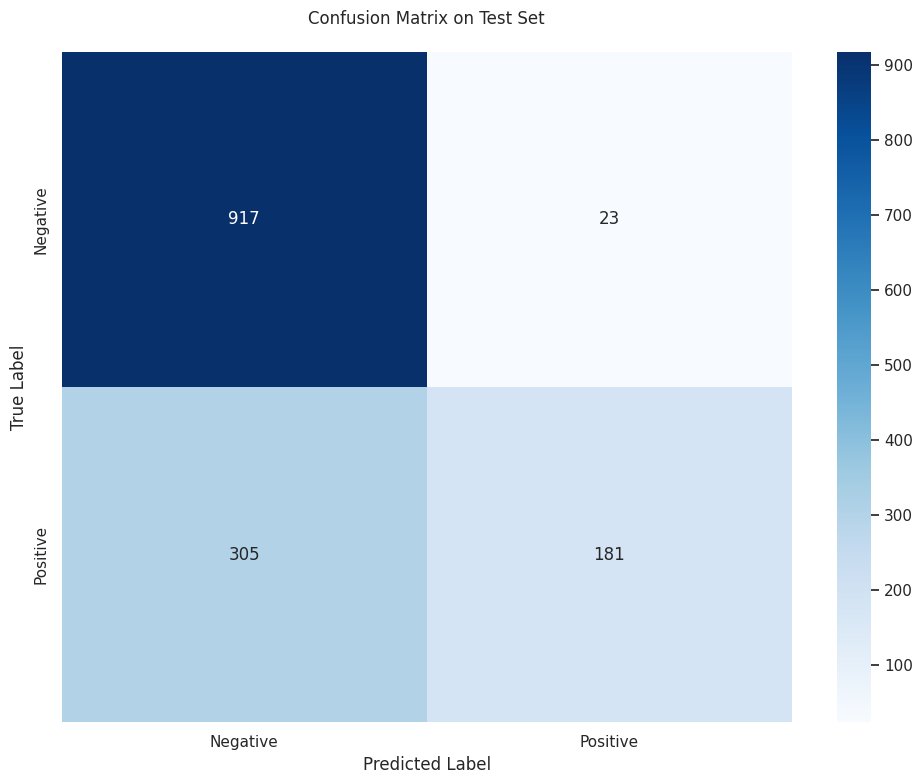

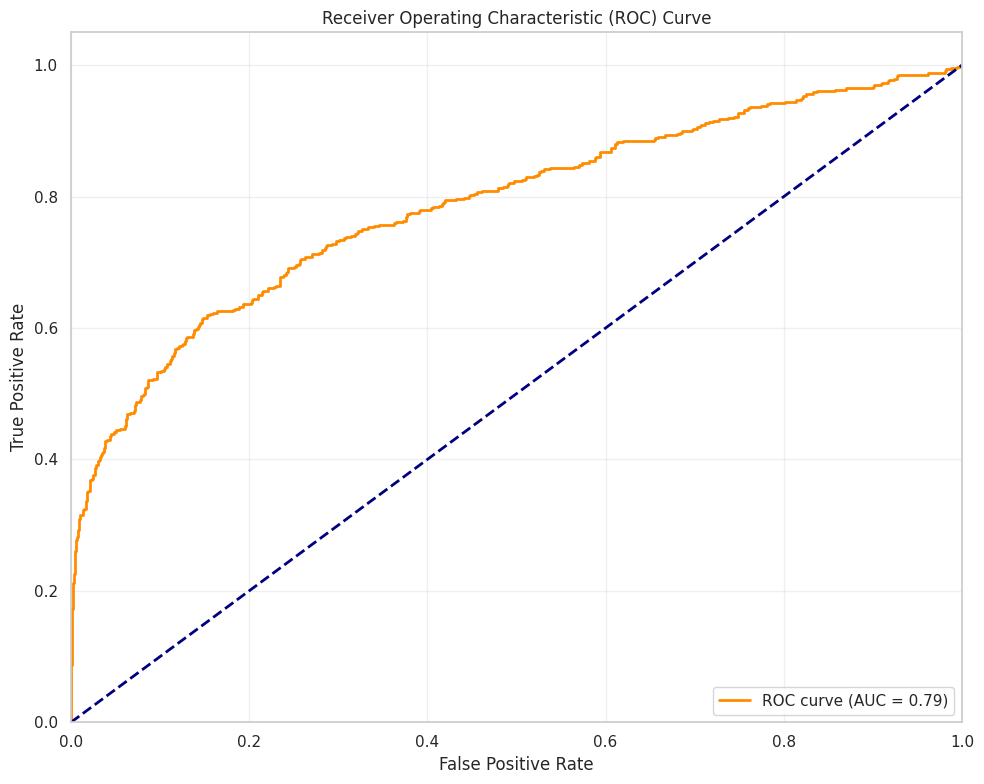

In [12]:
## Test Set Evaluation
import seaborn as sns
import matplotlib.pyplot as plt
print("Evaluating model on test set...")
model.eval()  # Set the model to evaluation mode

# Initialize metrics
test_loss = 0.0
total = 0
correct = 0
test_labels = []
test_predictions = []
test_raw_predictions = []  # For storing raw probabilities

with torch.no_grad():
    for data in test_loader:
        inputs_cc, inputs_mlo, labels = data
        inputs_cc = inputs_cc.float().to(device)
        inputs_mlo = inputs_mlo.float().to(device)
        labels = labels.float().to(device)
        
        labels = labels.unsqueeze(1)
        predicted = model(inputs_cc, inputs_mlo)
        
        # Calculate loss
        loss = criterion(predicted, labels)
        test_loss += loss.item()
        
        # Apply threshold
        thresholded_preds = (predicted > threshold).float()
        
        # Update metrics
        total += labels.size(0)
        correct += (thresholded_preds == labels).sum().item()
        
        # Store predictions and labels for metrics computation
        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(thresholded_preds.cpu().numpy())
        test_raw_predictions.extend(predicted.cpu().numpy())

# Calculate metrics
test_loss = test_loss / len(test_loader)
test_acc = 100 * correct / total
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)

# Print results
print("\nTest Set Metrics:")
print(f"  Loss: {test_loss:.5f}")
print(f"  Accuracy: {test_acc:.3f}%")
print(f"  Precision: {test_precision:.3f}")
print(f"  Recall: {test_recall:.3f}")
print(f"  F1 Score: {test_f1:.3f}")

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix

# Create and plot confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")  # Set seaborn theme
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix on Test Set', pad=20)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# ROC curve and AUC score
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_labels, test_raw_predictions)
roc_auc = auc(fpr, tpr)

# Set style for ROC curve
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")  # Reset style for new plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Ensamble Model Evaluation on Test Set
After training, let's evaluate the model's performance on the test set to get unbiased metrics.

In [87]:
class MakeDataset_VinDr_Ensemble(Dataset):
    def __init__(self,
                 image_dir: str,
                 label_csv: str,
                 transform=None,
                 mode: str = 'train',
                 split_size: float = 0.2,
                 target_size: int = 384):
        self.image_dir = image_dir
        self.transform = transform
        self.target_size = target_size

        # 1. Load and filter CSV
        df = pd.read_csv(label_csv)
        df = df.dropna(subset=['img_path', 'laterality', 'view_position', 'breast_birads'])

        # 2. Clean BI-RADS labels
        df['breast_birads'] = (
            df['breast_birads']
            .astype(str)
            .str.replace(r'^\s*BI-?RADS\s*', '', regex=True)
        )
        df['breast_birads'] = pd.to_numeric(df['breast_birads'], errors='coerce')
        df = df.dropna(subset=['breast_birads'])
        df['breast_birads'] = df['breast_birads'].astype(int)

        # 3. Map BI-RADS to 3-class labels:
        # 0 = Normal (BI-RADS 1)
        # 1 = Benign (BI-RADS 2–3)
        # 2 = Malignant (BI-RADS 4–6)
        def map_label(birads):
            if birads == 1:
                return 0
            elif 2 <= birads <= 3:
                return 1
            else:
                return 2

        df['label'] = df['breast_birads'].apply(map_label)

        print("\nView distribution:")
        print(df['view_position'].value_counts())
        print("\nLaterality distribution:")
        print(df['laterality'].value_counts())

        # 4. Build image lookup mapping
        self.image_map = {}
        for full_path in glob.glob(os.path.join(image_dir, '**', '*.*'), recursive=True):
            rel = os.path.relpath(full_path, image_dir)
            self.image_map[rel] = full_path
            base = os.path.basename(rel)
            if base not in self.image_map:
                self.image_map[base] = full_path

        # 5. Pair up CC and MLO images
        samples = []
        grouped = df.groupby(['study_id', 'laterality'])
        for (study_id, laterality), group in grouped:
            cc = group[group['view_position'] == 'CC']
            mlo = group[group['view_position'] == 'MLO']
            if cc.empty or mlo.empty:
                continue
            cc_rel = cc.iloc[0]['img_path']
            mlo_rel = mlo.iloc[0]['img_path']
            try:
                cc_full = self.find_image_path(cc_rel)
                mlo_full = self.find_image_path(mlo_rel)
            except FileNotFoundError as e:
                print(f"[Warning] Missing file for {study_id} {laterality}: {e}")
                continue
            label = int(cc.iloc[0]['label'])
            samples.append((cc_full, mlo_full, label))

        # 6. Shuffle and split
        np.random.seed(42)
        idx = np.random.permutation(len(samples))
        if mode == 'train':
            split_at = int(len(samples) * (1 - split_size))
            sel = idx[:split_at]
        elif mode == 'val':
            split_at = int(len(samples) * (1 - split_size))
            sel = idx[split_at:]
        else:  # test mode
            sel = idx
        self.samples = [samples[i] for i in sel]

        print(f"Initial count: {len(df)}")
        print(f"After dropna: {len(df)}")
        print(f"Unique study_ids: {df['study_id'].nunique()}")
        print(f"Final paired samples: {len(samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        cc_path, mlo_path, label = self.samples[idx]
        cc = Image.open(cc_path).convert('RGB')
        mlo = Image.open(mlo_path).convert('RGB')
        if self.transform:
            cc = self.transform(cc)
            mlo = self.transform(mlo)
        return cc, mlo, label

    def find_image_path(self, img_relpath: str) -> str:
        if img_relpath in self.image_map:
            return self.image_map[img_relpath]
        base = os.path.basename(img_relpath)
        if base in self.image_map:
            return self.image_map[base]
        raise FileNotFoundError(f"No match for {img_relpath}")

In [ ]:
""""
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Create splits folder
os.makedirs("splits", exist_ok=True)

# Load CSV
df = pd.read_csv("Dataset/remaining_full_path.csv")
df = df.dropna(subset=['img_path', 'laterality', 'view_position', 'breast_birads'])

# Clean birads
df['breast_birads'] = (
    df['breast_birads']
    .astype(str)
    .str.replace(r'^\s*BI-?RADS\s*', '', regex=True)
)
df['breast_birads'] = pd.to_numeric(df['breast_birads'], errors='coerce')
df = df.dropna(subset=['breast_birads'])
df['breast_birads'] = df['breast_birads'].astype(int)

# Map to 3 classes
def map_label(birads):
    if birads == 1:
        return 0  # Normal
    elif 2 <= birads <= 3:
        return 1  # Benign
    else:
        return 2  # Malignant

df['label'] = df['breast_birads'].apply(map_label)

# ✅ First split: Train+Val (90%) vs Test (10%)
trainval_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df['label'], random_state=42
)

# ✅ Second split: Train (70%) vs Val (20%) inside Train+Val
train_df, val_df = train_test_split(
    trainval_df, test_size=0.1667, stratify=trainval_df['label'], random_state=42
)
# (0.1667 ≈ 1/6 → ensures 70/20/10 overall)

# Save to CSVs in splits folder
train_df.to_csv("splits/train_labels.csv", index=False)
val_df.to_csv("splits/val_labels.csv", index=False)
test_df.to_csv("splits/test_labels.csv", index=False)

print("CSVs saved in 'splits/' folder")
print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

print("\nLabel distribution in train set:\n", train_df['label'].value_counts(normalize=True))
print("\nLabel distribution in val set:\n", val_df['label'].value_counts(normalize=True))
print("\nLabel distribution in test set:\n", test_df['label'].value_counts(normalize=True))
"""

CSVs saved in 'splits/' folder
Train size: 14598
Val size: 2921
Test size: 1947

Label distribution in train set:
 label
0    0.654884
1    0.275586
2    0.069530
Name: proportion, dtype: float64

Label distribution in val set:
 label
0    0.654913
1    0.275591
2    0.069497
Name: proportion, dtype: float64

Label distribution in test set:
 label
0    0.654854
1    0.275809
2    0.069337
Name: proportion, dtype: float64


In [88]:
## Data Loader (only Test set)
from torch.utils.data import DataLoader
import torch
import pandas as pd
from PIL import Image
import os
import glob
# Define transforms - DenseNet expects normalized inputs
transform = transforms.Compose([
    transforms.Resize((target_size, target_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# ==========================
# Load Test Dataset from CSV
# ==========================


test_dataset = MakeDataset_VinDr_Ensemble(
    image_dir=image_dir,
    label_csv=label_dir_csv,
    transform=transform,
    mode='test',         # You can use "test" here since no internal splitting
    split_size=0.0,      # No need for internal splitting
    target_size=target_size
)

# Test DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Print size to verify
print(f"Test dataset size: {len(test_dataset)}")


/home/intern04/miniconda3/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(



View distribution:
view_position
MLO    516
CC     504
Name: count, dtype: int64

Laterality distribution:
laterality
R    514
L    506
Name: count, dtype: int64
Initial count: 1020
After dropna: 1020
Unique study_ids: 250
Final paired samples: 500
Test dataset size: 500


In [89]:
from collections import Counter

def get_label_distribution(subset, name="Subset"):
    labels = [subset.dataset.samples[i][2] for i in subset.indices]
    counter = Counter(labels)
    total = sum(counter.values())
    print(f"\n{name} Class Distribution:")
    for cls in sorted(counter.keys()):
        label_name = (
            "Normal" if cls == 0 else
            "Benign" if cls == 1 else
            "Malignant"
        )
        print(f"Class {cls} ({label_name}): {counter[cls]} samples ({(counter[cls] / total) * 100:.2f}%)")
    print(f"Total samples: {total}")


In [90]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from models.densenet121 import create_model  # Your architecture

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Stage 1: Negative vs Positive
stage1_model = create_model(num_classes=1, pretrained=False)
stage1_model.load_state_dict(torch.load("densenet121_weights.pt", map_location=device))
stage1_model.to(device)
stage1_model.eval()

# Load Stage 2: Benign vs Malignant
stage2_model = create_model(num_classes=1, pretrained=False)
stage2_model.load_state_dict(torch.load("densenet121stage2_weights.pt", map_location=device))
stage2_model.to(device)
stage2_model.eval()




/home/intern04/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intern04/miniconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MultiViewDenseNet121(
  (densenet_cc): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e

In [ ]:
threshold = 0.69# adjust if needed

# Final labels encoding:
# 0 = Negative, 1 = Benign, 2 = Malignant

In [95]:
all_preds = []
all_labels = []

stage1_model.eval()
stage2_model.eval()

with torch.no_grad():
    for inputs_cc, inputs_mlo, labels in test_loader:
        inputs_cc = inputs_cc.float().to(device)
        inputs_mlo = inputs_mlo.float().to(device)
        labels_np = labels.cpu().numpy()  # store numpy labels separately

        for i in range(inputs_cc.size(0)):  # per-image loop
            cc_img = inputs_cc[i].unsqueeze(0)
            mlo_img = inputs_mlo[i].unsqueeze(0)

            # Stage 1
            out1 = torch.sigmoid(stage1_model(cc_img, mlo_img))
            pred1 = (out1 > threshold).item()

            if pred1 == 0:
                final_pred = 0  # Negative
            else:
                # Stage 2
                out2 = torch.sigmoid(stage2_model(cc_img, mlo_img))
                pred2 = (out2 > threshold).item()
                final_pred = 1 if pred2 == 0 else 2

            all_preds.append(final_pred)

        all_labels.extend(labels_np)  # keep alignment




In [20]:
np.unique(all_labels)

array([0, 1, 2])

In [21]:
np.unique(all_preds)

array([0, 1, 2])

In [96]:
# Compute metrics
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")


Test Accuracy: 0.7100
Precision: 0.583
Recall: 0.461
F1 Score: 0.448


In [77]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_two_stage(stage1_model, stage2_model, dataloader, device):
    stage1_model.eval()
    stage2_model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for cc, mlo, labels in dataloader:
            cc, mlo, labels = cc.to(device), mlo.to(device), labels.to(device)
            
            # -------- Stage 1: Negative vs Positive --------
            stage1_outputs = stage1_model(cc, mlo)  # shape: [batch_size, 2] or [batch_size, 1]
            stage1_preds = torch.argmax(stage1_outputs, dim=1)  # 0 = Normal, 1 = Positive
            
            # Initialize batch predictions as stage1 predictions
            batch_preds = stage1_preds.clone()
            
            # -------- Stage 2: Benign vs Malignant --------
            # Only for Stage 1 positive samples
            pos_indices = (stage1_preds == 1).nonzero(as_tuple=True)[0]
            if len(pos_indices) > 0:
                cc_pos = cc[pos_indices]
                mlo_pos = mlo[pos_indices]
                
                stage2_outputs = stage2_model(cc_pos, mlo_pos)  # shape: [num_pos, 2]
                stage2_preds = torch.argmax(stage2_outputs, dim=1) + 1  # Map 0->1 (Benign), 1->2 (Malignant)
                
                # Replace Stage 1 positive predictions with Stage 2 output
                batch_preds[pos_indices] = stage2_preds
            
            all_preds.extend(batch_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # -------- Metrics --------
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"Combined Test Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")
    
    return all_preds, all_labels


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Make sure your models are already loaded
# stage1_model and stage2_model

from torch.utils.data import DataLoader

test_loader = DataLoader(test_subset, batch_size=16, shuffle=False)

preds, labels = evaluate_two_stage(stage1_model, stage2_model, test_loader, device)


Combined Test Accuracy: 0.6592
Precision: 0.4345, Recall: 0.6592, F1-score: 0.5238


/home/intern04/miniconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
